In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [43]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# from collections import namedtuple, deque
from itertools import count
from PIL import Image
import time
import imageio

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# env = gym.make('CartPole-v1').unwrapped
ENV_NAME = 'BreakoutDeterministic-v4'

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
device

device(type='cuda')

In [ ]:
class FrameProcessor(object):
  def __init__(self, frame_height=84, frame_width=84):
    self.frame_height = frame_height
    self.frame_width = frame_width
    # self.frame = np.empty((210, 160, 3), dtype=np.uint8)
    self.resize = T.Compose([T.ToPILImage(),
                             T.Grayscale(),
                             T.Resize((self.frame_height,self.frame_width), interpolation=Image.CUBIC),
                             T.ToTensor()])

  def __call__(self, frame):
    frame = frame.transpose((2, 0, 1))  # transpose into torch order (CHW)
    # frame = np.ascontiguousarray(frame, dtype=np.float32) / 255
    frame = torch.from_numpy(frame)
    # Resize, and add a batch dimension (BCHW)
    return self.resize(frame)
    # return self.resize(frame).permute((1,2,0)).to(device)

In [ ]:
class Breakout(object):
  def __init__(self, env_name, no_op_steps=10, agent_history_length=4):
    self.env = gym.make(env_name)
    self.process_frame = FrameProcessor()
    self.state = None
    self.last_lives = 0
    self.no_op_steps = no_op_steps
    self.agent_history_length = agent_history_length

  def reset(self, evaluation=False):
    """
    Args:
        sess: A Tensorflow session object
        evaluation: A boolean saying whether the agent is evaluating or training
    Resets the environment and stacks four frames ontop of each other to 
    create the first state
    """
    frame = self.env.reset()
    self.last_lives = 0
    terminal_life_lost = True # Set to true so that the agent starts 
                              # with a 'FIRE' action when evaluating
    if evaluation:
        for _ in range(random.randint(1, self.no_op_steps)):
            frame, _, _, _ = self.env.step(1) # Action 'Fire'
    processed_frame = self.process_frame(frame)  
    self.state = processed_frame.repeat(self.agent_history_length, 1, 1)
    # self.state = processed_frame.repeat(1, 1, self.agent_history_length)
    
    return terminal_life_lost

  def step(self, action):
    """
    Args:
        sess: A Tensorflow session object
        action: Integer, action the agent performs
    Performs an action and observes the reward and terminal state from the environment
    """
    new_frame, reward, terminal, info = self.env.step(action)
        
    if info['ale.lives'] < self.last_lives:
        terminal_life_lost = True
    else:
        terminal_life_lost = terminal
    self.last_lives = info['ale.lives']
    
    processed_new_frame = self.process_frame(new_frame)
    new_state = torch.cat((self.state[1:, :, :], processed_new_frame), dim = 0)
    # new_state = torch.cat((self.state[:, :, 1:], processed_new_frame), dim=2)
    self.state = new_state
    
    return processed_new_frame, reward, terminal, terminal_life_lost, new_frame

In [ ]:
class ReplayMemory(object):

    def __init__(self, size, frame_height=84, frame_width=84, agent_replay_history=4, batch_size=32):
        self.size = size
        
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.agent_replay_history = agent_replay_history
        self.batch_size = batch_size


        self.rewards = torch.empty(self.size, device=device, dtype=torch.uint8)
        self.actions = torch.empty(self.size, device=device, dtype=torch.uint8)
        self.frames = torch.empty((self.size, self.frame_height, self.frame_width), device=device,dtype=torch.uint8)
        self.done_flags = torch.empty(self.size, device=device, dtype=torch.uint8)

        self.states = torch.empty((self.batch_size, self.agent_replay_history, self.frame_height, self.frame_width), device=device, dtype=torch.uint8)
        self.next_states = torch.empty((self.batch_size, self.agent_replay_history, self.frame_height, self.frame_width), device=device, dtype=torch.uint8)
        self.indices = torch.empty(self.batch_size, dtype=torch.int32)

        # self.rewards = np.empty(self.size, dtype=np.uint8)
        # self.actions = np.empty(self.size, dtype=np.uint8)
        # self.frames = np.empty((self.size, self.frame_height, self.frame_width), dtype=np.uint8)
        # self.done_flags = np.empty(self.size, dtype=np.uint8)

        # self.states = np.empty((self.batch_size, self.agent_replay_history, self.frame_height, self.frame_width), dtype=np.uint8)
        # self.next_states = np.empty((self.batch_size, self.agent_replay_history, self.frame_height, self.frame_width), dtype=np.uint8)
        # self.indices = np.empty(self.batch_size, dtype=np.uint32)

        self.current_position = 0
        self.current_size = 0

    def add_experience(self, action, frame, reward, done):
        """Saves a transition."""
        if frame.shape != (self.frame_height, self.frame_width):
          print (frame.shape)
          raise ValueError("Frame dimension is of wrong size")

        self.actions[self.current_position] = action
        self.rewards[self.current_position] = reward
        self.done_flags[self.current_position] = done
        # import pdb; pdb.set_trace()
        self.frames[self.current_position, ...] = 255*frame

        self.current_size = max(self.current_size, self.current_position)
        self.current_position = (self.current_position + 1) % self.size

    def _get_valid_indices(self):
        for i in range(self.batch_size):
          while True:
            index = random.randint(self.agent_replay_history, self.current_size)
            if index < self.agent_replay_history:
              continue
            if index >= self.current_position and index - self.agent_replay_history <= self.current_position:
              continue
            if self.done_flags[index-self.agent_replay_history:index].byte().any():
              continue
            break
          self.indices[i] = index

    def _get_state(self, index):
      return self.frames[index-self.agent_replay_history:index, ...]

    def get_MiniBatch(self):
      if self.current_size < self.batch_size:
        raise ValueError("Not enough experience in memory")
      
      self._get_valid_indices()
      for i, idx in enumerate(self.indices):
        self.states[i] = self._get_state(idx)
        self.next_states[i] = self._get_state(idx+1)
    #   plt.imshow(np.array(self.states[0,0,:,:].cpu()))
      self.indices = self.indices.type(torch.LongTensor)
      return self.states.type(torch.FloatTensor).to(device), self.actions[self.indices].unsqueeze(1).type(torch.LongTensor).to(device), self.rewards[self.indices].to(device), \
      self.next_states.type(torch.FloatTensor).to(device), self.done_flags[self.indices].to(device)
    
    def __len__(self):
        return self.current_size

In [ ]:
class ExplorationExploitationScheduler(object):
    def __init__(self, n_actions, eps_initial=1, eps_final=0.1, eps_final_frame=0.01, 
                 eps_evaluation=0.0, eps_annealing_frames=1000000, 
                 replay_memory_start_size=50000, max_frames=25000000):
        
        self.n_actions = n_actions
        self.eps_initial = eps_initial
        self.eps_final = eps_final
        self.eps_final_frame = eps_final_frame
        self.eps_evaluation = eps_evaluation
        self.eps_annealing_frames = eps_annealing_frames
        self.replay_memory_start_size = replay_memory_start_size
        self.max_frames = max_frames
        
        # Slopes and intercepts for exploration decrease
        self.slope = -(self.eps_initial - self.eps_final)/self.eps_annealing_frames
        self.intercept = self.eps_initial - self.slope*self.replay_memory_start_size
        self.slope_2 = -(self.eps_final - self.eps_final_frame)/(self.max_frames - self.eps_annealing_frames - self.replay_memory_start_size)
        self.intercept_2 = self.eps_final_frame - self.slope_2*self.max_frames
        
    def get_action(self, policy_net, frame_number, state, evaluation=False):
       
        if evaluation:
            eps = self.eps_evaluation
        elif frame_number < self.replay_memory_start_size:
            eps = self.eps_initial
        elif frame_number >= self.replay_memory_start_size and frame_number < self.replay_memory_start_size + self.eps_annealing_frames:
            eps = self.slope*frame_number + self.intercept
        elif frame_number >= self.replay_memory_start_size + self.eps_annealing_frames:
            eps = self.slope_2*frame_number + self.intercept_2
        
        if np.random.rand(1) < eps:
            return np.random.randint(0, self.n_actions)
        return policy_net.act(state)
        # return policy_net(state.unsqueeze(0)).max(1)[1].view(1, 1)

In [ ]:
class DQN(nn.Module):

    def __init__(self, num_actions, agent_replay_history=4):
        super(DQN, self).__init__()

        self.input_shape = agent_replay_history
        self.num_outputs = num_actions
        # self.conv1 = nn.Conv2d(self.agent_replay_history, 16, kernel_size=5, stride=2)
        # self.bn1 = nn.BatchNorm2d(16)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        # self.bn2 = nn.BatchNorm2d(32)
        # self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        # self.bn3 = nn.BatchNorm2d(32)
        # self.head = nn.Linear(1568, num_actions)

        self.features = nn.Sequential(
            nn.Conv2d(self.input_shape, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 

        self.advantage = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def feature_size(self):
        return 64 * 7 * 7
        # return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)

    def forward(self, x):
        # print (x.shape)
        x = self.features(x)
        # print (x.shape)
        x = x.view(x.size(0), -1)
        # print (x.shape)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()

    def act(self, state):
        state   = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
        q_value = self.forward(state)
        action  = q_value.max(1)[1].data[0]
        return action

In [52]:
# Control parameters
MAX_EPISODE_LENGTH = 18000       # Equivalent of 5 minutes of gameplay at 60 frames per second
EVAL_FREQUENCY = 200000          # Number of frames the agent sees between evaluations
# EVAL_FREQUENCY = 0          # Number of frames the agent sees between evaluations
EVAL_STEPS = 10000               # Number of frames for one evaluation
NETW_UPDATE_FREQ = 10000         # Number of chosen actions between updating the target network. 
                                 # According to Mnih et al. 2015 this is measured in the number of 
                                 # parameter updates (every four actions), however, in the 
                                 # DeepMind code, it is clearly measured in the number
                                 # of actions the agent choses
DISCOUNT_FACTOR = 0.99           # gamma in the Bellman equation
REPLAY_MEMORY_START_SIZE = 50000 # Number of completely random actions, 
                                 # before the agent starts learning
MAX_FRAMES = 30000000            # Total number of frames the agent sees 
# MAX_FRAMES = 100000            # Total number of frames the agent sees 

MEMORY_SIZE = 1000000            # Number of transitions stored in the replay memory
NO_OP_STEPS = 10                 # Number of 'NOOP' or 'FIRE' actions at the beginning of an 
                                 # evaluation episode
UPDATE_FREQ = 4                  # Every four actions a gradient descend step is performed
LEARNING_RATE = 0.0000625          # Set to 0.00025 in Pong for quicker results. 
                                 # Hessel et al. 2017 used 0.0000625
BS = 32                          # Batch size
PATH = f"/content/gdrive/My Drive/ModelFiles/"
breakout = Breakout(ENV_NAME, NO_OP_STEPS)

print("The environment has the following {} actions: {}".format(breakout.env.action_space.n, 
                                                                breakout.env.unwrapped.get_action_meanings()))

The environment has the following 4 actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [ ]:
num_actions = breakout.env.action_space.n

policy_net = DQN(num_actions, agent_replay_history=4).to(device)
target_net = DQN(num_actions, agent_replay_history=4).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.RMSprop(policy_net.parameters(), lr=LEARNING_RATE)
# memory = ReplayMemory(10000)
# steps_done = 0

In [54]:
policy_net

DQN(
  (features): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (advantage): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
  (value): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
total_rewards = []
total_loss = []

In [ ]:
# model = torch.load("/content/gdrive/My Drive/ModelFiles/myModel-3406376.pth")
# model = torch.load("/content/gdrive/My Drive/ModelFiles/myModel-5211428.pth")
# model = torch.load("/content/gdrive/My Drive/ModelFiles/myModel-7819868.pth")

In [28]:
# model.keys()

dict_keys(['state_dict', 'rewards', 'loss_list', 'frame_number', 'optimizer'])

In [ ]:
# policy_net.load_state_dict(model['state_dict'])
# target_net.load_state_dict(model['state_dict'])
# optimizer.load_state_dict(model['optimizer'])

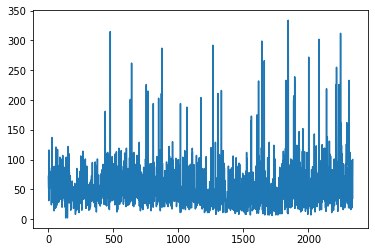

In [30]:
# plt.plot(model['rewards'])

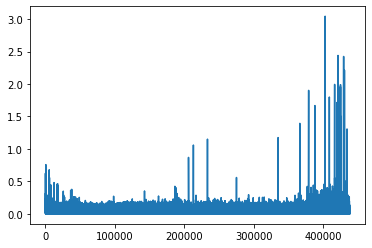

In [24]:
# plt.plot(model['loss_list'])

In [ ]:
# new_frame_number = model['frame_number']
# print(new_frame_number)
new_frame_number = False

5211428


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

from skimage.transform import resize
def generate_gif(frame_number, frames_for_gif, reward, path):
    """
        Args:
            frame_number: Integer, determining the number of the current frame
            frames_for_gif: A sequence of (210, 160, 3) frames of an Atari game in RGB
            reward: Integer, Total reward of the episode that es ouputted as a gif
            path: String, path where gif is saved
    """
    for idx, frame_idx in enumerate(frames_for_gif): 
        frames_for_gif[idx] = resize(frame_idx, (320, 320, 3), 
                                     preserve_range=True, order=0)
        
    imageio.mimsave(f'{path}{"ATARI_frame_{0}_reward_{1}.gif".format(frame_number, reward)}', 
                    frames_for_gif, duration=1/30)

In [ ]:
def clip_reward(reward):
    if reward > 0:
        return 1
    elif reward == 0:
        return 0
    else:
        return -1

In [ ]:
def learn(replay_memory, policy_net, target_net, gamma):
    optimizer.zero_grad()
    states, actions, rewards, new_states, terminal_flags = replay_memory.get_MiniBatch()    
    # import pdb; pdb.set_trace()
    q_value = policy_net(states).gather(1, actions)
    next_q_values = target_net(new_states).max(1)[0].detach()
    expected_state_action_values = rewards + (gamma * next_q_values * (1 - terminal_flags)) 
    loss = F.smooth_l1_loss(q_value, expected_state_action_values.unsqueeze(1))

    loss.backward()
    optimizer.step()
    return loss

In [ ]:
def train():
    global REPLAY_MEMORY_START_SIZE

    my_replay_memory = ReplayMemory(size=MEMORY_SIZE, batch_size=BS)
    explore_exploit_sched = ExplorationExploitationScheduler(
          breakout.env.action_space.n, 
          replay_memory_start_size=REPLAY_MEMORY_START_SIZE, 
          max_frames=MAX_FRAMES)
    

    frame_number = 0
    if new_frame_number:
        frame_number = new_frame_number
        REPLAY_MEMORY_START_SIZE += frame_number

    rewards = []
    loss_list = []

    while frame_number < MAX_FRAMES:
        epoch_frame = 0
        display.clear_output()
        while epoch_frame < EVAL_FREQUENCY:
            terminal_life_lost = breakout.reset()
            episode_reward_sum = 0


            for _ in range(MAX_EPISODE_LENGTH):
                action = explore_exploit_sched.get_action(policy_net, frame_number, breakout.state)   
                processed_new_frame, reward, terminal, terminal_life_lost, _ = breakout.step(action)
                frame_number += 1
                epoch_frame += 1
                episode_reward_sum += reward
                
                # Clip the reward
                clipped_reward = clip_reward(reward)
                # import pdb; pdb.set_trace()
                my_replay_memory.add_experience(action=action, 
                                                  frame=processed_new_frame[0, :, :],
                                                  reward=clipped_reward, 
                                                  done=terminal_life_lost)   
                if frame_number % UPDATE_FREQ == 0 and frame_number > REPLAY_MEMORY_START_SIZE:
                    loss = learn(my_replay_memory, policy_net, target_net, DISCOUNT_FACTOR)
                    loss_list.append(loss)
   
                if frame_number % NETW_UPDATE_FREQ == 0 and frame_number > REPLAY_MEMORY_START_SIZE:
                    target_net.load_state_dict(policy_net.state_dict())

                if terminal:
                    terminal = False
                    break

            rewards.append(episode_reward_sum)

            if len(rewards) % 10 == 0:
                if frame_number > REPLAY_MEMORY_START_SIZE:
                    print(len(rewards), frame_number, epoch_frame, np.mean(rewards[-100:]))


        print ("EVALUATION STARTS")
        print (frame_number, epoch_frame)
        terminal = True
        gif = True
        frames_for_gif = []
        eval_rewards = []
        evaluate_frame_number = 0
        
        for _ in range(EVAL_STEPS):
            if terminal:
                terminal_life_lost = breakout.reset(evaluation=True)
                episode_reward_sum = 0
                terminal = False
          
            # Fire (action 1), when a life was lost or the game just started, 
            # so that the agent does not stand around doing nothing. When playing 
            # with other environments, you might want to change this...
            action = 1 if terminal_life_lost else explore_exploit_sched.get_action(policy_net, frame_number,
                                                                                  breakout.state, 
                                                                                  evaluation=True)
            
            processed_new_frame, reward, terminal, terminal_life_lost, new_frame = breakout.step(action)
            evaluate_frame_number += 1
            episode_reward_sum += reward

            if gif: 
                frames_for_gif.append(new_frame)
            if terminal:
                eval_rewards.append(episode_reward_sum)
                gif = False # Save only the first game of the evaluation as a gif
                
        print("Evaluation score:\n", np.mean(eval_rewards))
        generate_gif(frame_number, frames_for_gif, eval_rewards[0], PATH)

        torch.save({'state_dict': policy_net.state_dict(),
                    'rewards': rewards,
                    'loss_list': loss_list,
                    'frame_number': frame_number,
                    'optimizer': optimizer.state_dict()}, PATH + "myModel-" +str(frame_number)+".pth")


In [22]:
train()

2350 7829175 9307 61.77
2360 7843021 23153 61.9
2370 7854949 35081 62.38
2380 7867854 47986 64.55
2390 7880599 60731 66.66
2400 7891290 71422 63.77
2410 7906102 86234 67.74
2420 7917792 97924 67.62
2430 7928612 108744 67.53
2440 7939350 119482 67.72
2450 7951697 131829 65.97
2460 7963351 143483 63.32
2470 7974714 154846 62.0
2480 7986935 167067 60.66
2490 7998505 178637 59.38
2500 8010639 190771 58.18
EVALUATION STARTS
8020897 201029
Evaluation score:
 82.0


KeyboardInterrupt: ignored

In [ ]:
total_rewards.extend(model['rewards'])
total_loss.extend(model['loss_list'])

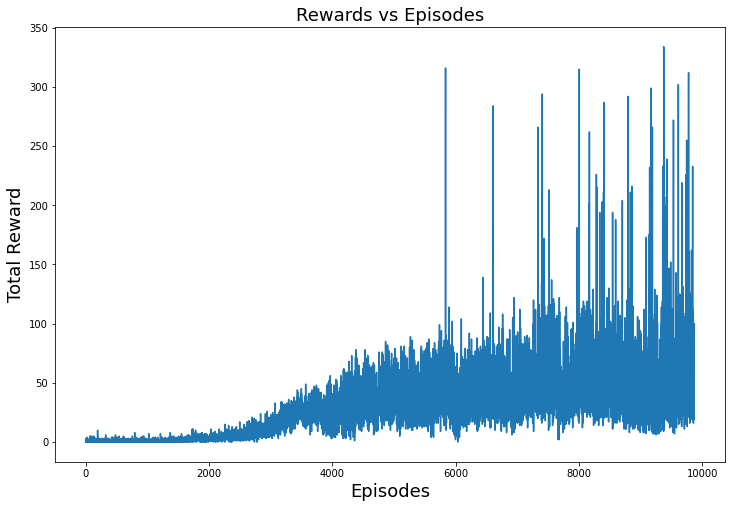

In [39]:
plt.figure(figsize=(12,8))
plt.title('Rewards vs Episodes', fontsize = 18)
plt.xlabel('Episodes', fontsize = 18)
plt.ylabel('Total Reward', fontsize=18)
plt.plot(total_rewards)
plt.savefig('/content/gdrive/My Drive/ModelFiles/BreakoutReward.jpg')

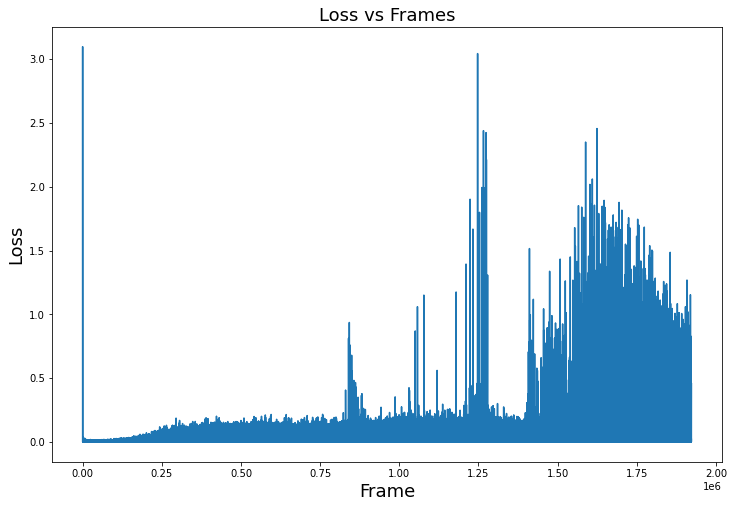

In [40]:
plt.figure(figsize=(12,8))
plt.title('Loss vs Frames', fontsize = 18)
plt.xlabel('Frame', fontsize = 18)
plt.ylabel('Loss', fontsize=18)
plt.plot(total_loss)
plt.savefig('/content/gdrive/My Drive/ModelFiles/BreakoutLoss.jpg')